In [1]:
import re

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

import pandas as pd
from statistics import median, mean

sns.set_style("darkgrid")

import matplotlib.dates as mdates
import numpy as np
import json

In [2]:
classes = pd.read_json("../data/classes.json", orient="records").T
classes.date = classes.date.map(lambda x: x + "T17:30")
classes.date = pd.to_datetime(classes.date, format="%d/%m/%YT%H:%M")
usernames = json.load(open("../data/usernames.json"))
readings = pd.read_csv("../data/readings.csv", index_col="id", parse_dates=['date'])
comments = pd.read_csv("../data/comments.csv", index_col="id", parse_dates=['created', 'updated'])
comments = comments.merge(readings[['url', 'week', 'part', 'date', 'required', 'speaker']], left_on="url_id", right_index=True)

In [69]:
URL_PATTERN = "((http|ftp|https):\/\/[\w\-_]+(\.[\w\-_]+)+([\w\-\.,@?^=%&amp;:/~\+#]*[\w\-\@?^=%&amp;/~\+#])?)"

our_comments = comments[comments.user.isin(usernames)]

In [3]:
def rand_jitter(arr):
    return arr + np.random.randn(len(arr)) * .05

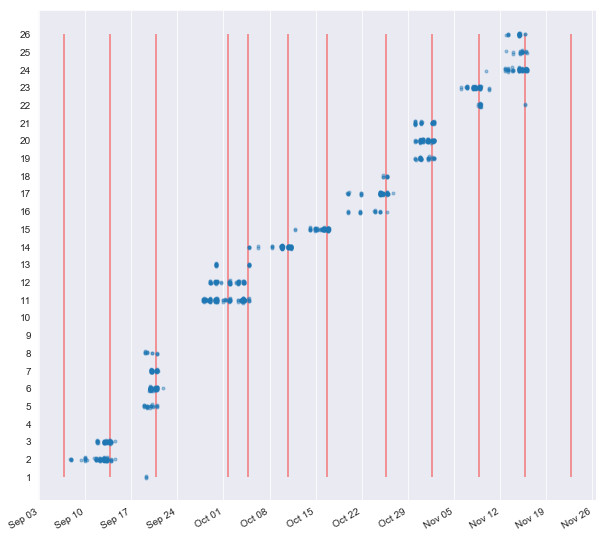

In [4]:
pdf = comments[comments.in_class == True]
fig, ax = plt.subplots(figsize=(10,10))

# sns.pointplot(x="created", y="url_id", hue="in_class", data=pdf, ci=None, join=False, ax=ax, marker=".")
ax.plot(pdf.created, rand_jitter(pdf.url_id), marker=".", ls='', alpha=.4)


ax.yaxis.set_ticks(range(1,27))
start, end = ax.get_ylim()
ax.vlines(classes.date.unique(), 1, 26, colors="r", alpha=.5)

mondays = mdates.WeekdayLocator(mdates.MONDAY)
ax.xaxis.set_major_locator(mondays)

weekFormatter = mdates.DateFormatter('%b %d')
ax.xaxis.set_major_formatter(weekFormatter)

#ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m'))
fig.autofmt_xdate()

ax.yaxis.grid(False)

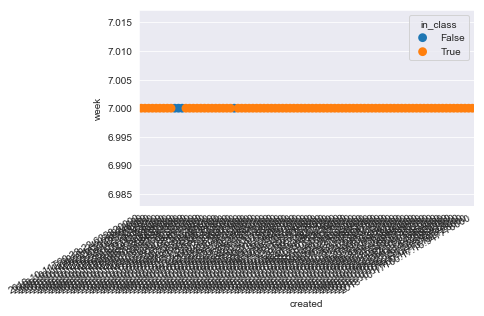

In [97]:
fig, ax = plt.subplots()

sns.pointplot(x="created", y="url_id", hue="in_class", data=pdf[pdf.week==7], ci=None, join=False, ax=ax, marker=".")

fig.autofmt_xdate()
ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')

,total,median,mean
total,1.000000,-0.255226,0.041804
median,-0.255226,1.000000,0.872527
mean,0.041804,0.872527,1.000000


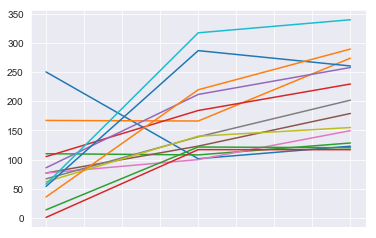

In [7]:
counts = pd.DataFrame(columns=["total", "median", "mean"])
counts['total'] = our_comments.user.value_counts()
counts['median'] = our_comments.groupby("user")["text"].apply(lambda x: median([len(str(y)) for y in x.tolist()]))
counts['mean'] = our_comments.groupby("user")["text"].apply(lambda x: mean([len(str(y)) for y in x.tolist()]))
counts.T.plot(legend=False)
counts.corr(method="spearman")

In [8]:
reading_times = pd.DataFrame(columns=["url_id", "week", "user", "sec", "comments"])

for user in usernames:
    for uid in comments.url_id.unique():
        c = comments[(comments.user==user)&(comments.url_id==uid)]
        count = len(c)
        if count > 1:
            reading_time = max(c.created)-min(c.updated)
            reading_time = int(reading_time.seconds // 60)
            reading_times.loc[len(reading_times)+1] = [uid, c.week.iloc[0], user, reading_time, count]
reading_times.sec = reading_times.sec.astype(int)
reading_times.comments = reading_times.comments.astype(int)

In [9]:
reading_times.groupby("user")['sec'].median()

user
Bubblbu                28.0
CSG                    40.0
KariGustafson          42.0
aliceLF                66.0
anastasiak             33.0
camilleweinsheimer     42.0
carina.albrecht        83.0
cypriine              408.0
juan                  494.0
mawaters               88.5
melissa_roach          32.0
michelle_la            74.0
vreichsh               20.0
Name: sec, dtype: float64

In [71]:
our_comments['contains_url'] = our_comments.text.map(lambda x: re.search(URL_PATTERN, x) is not None if not pd.isna(x) else None)
our_comments.groupby("user")['contains_url'].sum()

/home/asura/.virtualenvs/altmetrics/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


user
Bubblbu                 17
CSG                      0
KariGustafson            4
aliceLF                 29
anastasiak               0
camilleweinsheimer       0
carina.albrecht          9
cypriine                 3
juan                     2
kprosser              True
mawaters                 2
melissa_roach            4
michelle_la             20
vreichsh                 2
Name: contains_url, dtype: object